In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from datetime import timedelta
from pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objects as go

In [54]:
def get_cpi():
    cpi = pd.read_excel('data/CPIAUCSL (1).xls')
    #cpi = pd.read_csv("T5YIE.csv")
    cpi.columns = ["date", 'CPI']
    cpi["date"] = pd.to_datetime(cpi["date"]) - timedelta(days=1)
    return cpi

def get_stocks():
    stocks = pd.read_csv("data/stocks.csv")
    stocks["MthCalDt"] = pd.to_datetime(stocks["MthCalDt"])
    return stocks


def merge_cpi_stock(stocks, cpi):
    merged = pd.merge(stocks, cpi, how="left", left_on="MthCalDt", right_on="date")
    return merged

def bin_inflation_regimes(cpi, labels = ["deflation","low", "mid", "high"], bins = [-10, 0,1,3,20]):
    cpi["Inflation"] = pd.cut(cpi["CPI"],bins, labels=labels)
    return cpi

In [33]:
# get factors
def get_factors():

    ff_factors = pd.read_csv("data/ff_factors.csv")
    ff_factor_mom = pd.read_csv("data/ff_factor_umd.csv")
    ff_factors.rename({"Unnamed: 0": "date"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom":"UMD"}, axis=1, inplace=True)
    ff_factor_mom.rename({"Unnamed: 0": "date", "Mom   ":"UMD"}, axis=1, inplace=True)
    ff_factors = ff_factors.merge(ff_factor_mom, how="left", on="date")
    
    ff_factors["date"] = pd.to_datetime(ff_factors["date"], format="%Y%m")
    ff_factors["date"] += MonthEnd(0)


    return ff_factors

In [57]:
def get_company(merged, permno):
    comp = merged[merged["PERMNO"] == permno][["MthCalDt","MthRet"]]
    comp = comp.drop_duplicates(subset="MthCalDt", keep="first")
    comp = comp.set_index("MthCalDt")
    comp.index = comp.index + MonthEnd(0)

    return comp

In [58]:
def prep_reg(ff_factors, comp, remove_factors = []):
    removed_cols = ["RF"] + remove_factors
    X = ff_factors[[x for x in ff_factors.columns if not x in removed_cols]].set_index("date")
    comp["Excess Return"] = comp["MthRet"] - ff_factors.set_index("date")["RF"]
    y = comp['Excess Return']

    # get indies that are the same between X and y
    indies_X = X.index.intersection(y.index)

    indies_y = y.index.intersection(X.index)

    indies = indies_X.intersection(indies_y)

    # save those rows
    X = X.loc[indies]
    y = y.loc[indies]
    
    y = y * 100
    
    return X, y

In [59]:
def run_reg(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    results.summary()
    return results.params[1:]

In [117]:
cpi = get_cpi()

In [118]:
bins = [-10,0,1,3,20]
labels = ["deflation", "low", "mid", "high"]
cpi = bin_inflation_regimes(cpi, labels = labels, bins = bins)

In [124]:
# graph cpi with inflation regimes as 
fig = px.line(cpi, x="date", y="CPI")
colors = ["pink", "yellow", "green", "red"]
# add shades of color for inflation regimes
for bins_i in range(len(bins)-1):
    col = colors[bins_i]
    l_bin = bins[bins_i]
    u_bin = bins[bins_i+1]

    fig.add_hrect(y0 = l_bin, y1=u_bin, fillcolor=col, opacity=0.25, line_width=0)

# add vertical lines for major events with annotations


fig.add_vline(x="1971-12-01", line_width=1, line_dash="dash", line_color="blue")#, annotation_text = "Gold Standard", annotation_postion="bottom right")# annotation= "Gold Standard")
fig.add_vline(x="2020-03-01", line_width=1, line_dash="dash", line_color="blue")#, annotation_text= "COVID")
fig.add_vline(x="2008-06-01", line_width=1, line_dash="dash", line_color="blue")#, annotation= "Great Recession")
fig.add_vline(x="1950-06-01", line_width=1, line_dash="dash", line_color="blue")#, abbreviation= "Korean War")
fig.add_vline(x="1966-06-01", line_width=1, line_dash="dash", line_color="blue")#, abbreviation= "Vietnam War")
fig.add_vline(x="1978-06-01", line_width=1, line_dash="dash", line_color="blue")#), abbreviation= "Oil Crisis")

fig.add_annotation(x="1973-12-01", text="Gold Standard", showarrow=False, yref="paper", y=0.9, xref="x", yanchor="top")
fig.add_annotation(x="2021-03-01", text="COVID", showarrow=False, yref="paper", y=0.95, xref="x", yanchor="top")
fig.add_annotation(x="2009-06-01", text="Great Recession", showarrow=False, yref="paper", y=0.95, xref="x", yanchor="top")
fig.add_annotation(x="1953-06-01", text="Korean War", showarrow=False, yref="paper", y=0.95, xref="x", yanchor="top")
fig.add_annotation(x="1963-06-01", text="Vietnam War", showarrow=False, yref="paper", y=0.9, xref="x", yanchor="top")
fig.add_annotation(x="1979-06-01", text="Oil Crisis", showarrow=False, yref="paper", y=0.95, xref="x", yanchor="top")

fig.show()

In [179]:
stocks = get_stocks()
# cpi = bin_inflation_regimes(cpi)
merged = merge_cpi_stock(stocks, cpi)
ff_factors = get_factors()


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_36952/1925934932.py:9: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



<AxesSubplot:>

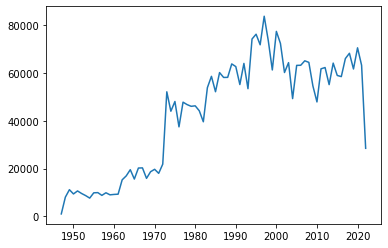

In [180]:
# value counts of years in merged
merged["date"].dt.year.value_counts().sort_index().plot()

In [181]:
# remove dates before 1985
# merged = merged[merged["date"] >= "1985-01-01"]

In [182]:
from tqdm import tqdm

In [183]:
# for each perno, get the excess return and run a regression
# save the betas
beta_dict = {}
for permno in tqdm(merged["PERMNO"].unique()):
    # supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            comp = get_company(merged, permno)
            if len(comp) < 12:
                continue
            X, y = prep_reg(ff_factors, comp)
            
            if (X.shape[0] < 2) or (y.shape[0] < 2):
                continue
            
            beta_dict[permno] = run_reg(X, y).values
        except ValueError:
            print("ValueError for permno: ", permno)
            break

100%|██████████| 36144/36144 [08:04<00:00, 74.66it/s] 


In [184]:
betas = pd.DataFrame(beta_dict).T
betas.columns = X.columns

In [185]:
betas.reset_index(inplace=True)

In [186]:
betas.rename({"index": "PERMNO"}, axis=1, inplace=True)

In [187]:
betas

,PERMNO,Mkt-RF,SMB,HML,RMW,CMA,UMD
0,10000,-0.756132,4.886128,2.610467,-4.477707,-6.509955,2.379360
1,10001,-0.075395,0.755356,0.056853,-0.232516,-0.337785,-0.559832
2,10002,0.122566,1.525182,1.142493,0.362636,-0.274842,-0.423107
3,10003,1.495267,5.543331,6.463190,0.181900,-1.655064,-0.263197
4,10005,1.327231,1.341277,-4.967922,-2.374611,8.207193,-3.695720
...,...,...,...,...,...,...,...
33488,93432,-0.589409,-6.024435,-4.946234,-11.587453,2.367807,5.060635
33489,93433,1.468938,-8.192412,2.555918,-1.553371,-9.722839,-8.709984
33490,93434,0.510665,0.281969,0.925659,-0.328132,-1.017246,-0.014302
33491,93435,2.138985,-0.872100,7.780030,-2.168000,-12.013305,0.983280


In [188]:
betas = betas.dropna()

In [189]:
merged_factors = pd.merge(merged, betas, how="inner", on="PERMNO")

In [190]:
merged_factors.isna().sum()

PERMNO               0
PrimaryExch          0
SecurityNm           0
Ticker            6067
SICCD                0
ICBIndustry          0
MthCalDt             0
MthPrc             212
MthRet             241
MthVol          247495
ShrOut           25372
date           1210457
CPI            1210457
Inflation      1210457
Mkt-RF               0
SMB                  0
HML                  0
RMW                  0
CMA                  0
UMD                  0
dtype: int64

In [191]:
merged.groupby("Inflation")["MthCalDt"].nunique()

Inflation
deflation     30
low           40
mid          266
high         291
Name: MthCalDt, dtype: int64

In [192]:
# create 4 dataframes, one for each inflation regime
deflated = merged_factors[merged_factors["Inflation"] == "deflation"].copy().dropna(subset=["MthRet"])
low = merged_factors[merged_factors["Inflation"] == "low"].copy().dropna(subset=["MthRet"])
mid = merged_factors[merged_factors["Inflation"] == "mid"].copy().dropna(subset=["MthRet"])
high = merged_factors[merged_factors["Inflation"] == "high"].copy().dropna(subset=["MthRet"])

{deflation: {mkt-rf: (x, y)} }

In [206]:
univar = False

X_factors = ["Mkt-RF","SMB","HML","RMW","CMA","UMD"]
y_returns = ["MthRet"]

regimes_names = ["deflated", "low", "mid", "high"]
#regimes_names = ["low", "mid", "high"]

regimes = [deflated, low, mid, high]
#regimes = [low, mid, high]
regime_betas = {}

for regime_i in range(len(regimes)):
    regime = regimes[regime_i]
    regime_name = regimes_names[regime_i]
    if univar:
        for factor in X_factors:
            X = regime[factor]
            y = regime[y_returns]
            X = sm.add_constant(X)
            model = sm.OLS(y, X)
            results = model.fit()
            
            regime_betas[(regime_name, factor)] = (results.params[factor], results.tvalues[factor])

    else:
        X = regime[X_factors]
        y = regime[y_returns]
        
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        for factor in X_factors:
            regime_betas[(regime_name, factor)] = (results.params[factor], results.tvalues[factor])
        


In [207]:
# dict to pandas dataframe multiindex
regime_df = pd.DataFrame(regime_betas).T
regime_df.columns = ["beta", "t-stat"]

In [208]:
regime_df

beta     t-stat
deflated Mkt-RF  0.027513  25.232717
         SMB     0.013895  17.819043
         HML     0.008972  11.215949
         RMW    -0.014248 -24.432908
         CMA    -0.001330  -2.144096
         UMD    -0.024670 -25.182939
low      Mkt-RF -0.003758  -5.445915
         SMB    -0.002557  -4.929982
         HML    -0.006227 -11.690011
         RMW     0.002511   6.605378
         CMA    -0.002031  -4.904954
         UMD     0.003260   5.886096
mid      Mkt-RF  0.006310  32.530717
         SMB     0.003149  22.999878
         HML    -0.002200 -17.800633
         RMW    -0.000655  -6.937320
         CMA    -0.002192 -21.051523
         UMD     0.002461  14.340779
high     Mkt-RF  0.001599   7.913601
         SMB    -0.000415  -3.420897
         HML    -0.000853  -7.837741
         RMW     0.000393   4.652132
         CMA    -0.000856  -9.773791
         UMD     0.001297   7.583793

In [209]:
regime_df_non_multi = regime_df.reset_index().rename({"level_0": "regime", "level_1": "factor"}, axis=1)

In [210]:
# plot the betas using plotly plot grouped by factor and regime
# make plot bigger

import plotly.express as px

fig = px.bar(regime_df_non_multi, x="factor", y="beta", color="regime", barmode="group")
fig.show()

In [212]:
'''
Mkt-RF: 
SMB: low infl is bigger firms, mid infl is smaller, high infl is both...deflated is small 
HML: Low infl is more growth, mid infl is both, high infl is more value...deflated very value
RMW: Low infl is more robust/stable, mid infl is weak, high infl is both...deflated is both
CMA: Low infl is more agg, mid infl is agg, high infl is conv...deflated is conv
UMD: Low infl is better than market, mid infl is better than market, high infl is better than market...deflated is worse than market

'''

'\nMkt-RF: \nSMB: low infl is bigger firms, mid infl is smaller, high infl is both...deflated is small \nHML: Low infl is more growth, mid infl is both, high infl is more value...deflated very value\nRMW: Low infl is more robust/stable, mid infl is weak, high infl is both...deflated is both\nCMA: Low infl is more agg, mid infl is agg, high infl is conv...deflated is conv\nUMD: Low infl is better than market, mid infl is better than market, high infl is better than market...deflated is worse than market\n\n'

In [213]:
fig = px.bar(regime_df_non_multi, x="factor", y="t-stat", color="regime", barmode="group")
fig.show()

In [ ]:
# data cleaning
# verfiy results
# rerun traditional model with lookahead
# bin deflation and low? (/)
# long short top and bottom 25% of each factor?
# run regression on each factor individually (/)